# Import libraries

In [1]:
import pathlib
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

# Read data from file

In [2]:
path = pathlib.Path('D:\DataScience\Real-Time-Data-Analysis\data\\raw\data.csv')

df = pd.read_csv(path,index_col='index',parse_dates=True)

# Looking into data

In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Date
index,,,,,,,
2022-12-19 12:15:00,18375.400391,18383.400391,18322.050781,18333.000000,18333.000000,0,NaN
2022-12-19 13:15:00,18331.599609,18375.650391,18327.550781,18366.949219,18366.949219,0,NaN
2022-12-19 14:15:00,18366.599609,18425.050781,18352.250000,18418.699219,18418.699219,0,NaN
2022-12-19 15:15:00,18418.650391,18431.250000,18416.599609,18426.199219,18426.199219,0,NaN
2022-12-19 15:30:00,18420.449219,18420.449219,18420.449219,18420.449219,18420.449219,0,NaN


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Date
count,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.0,0.0
mean,16562.510522,16594.031646,16525.848365,16561.266444,16561.266444,0.0,NaN
std,1277.003819,1275.067869,1279.931524,1277.153480,1277.153480,0.0,NaN
min,13253.349609,13296.700195,13135.099609,13241.599609,13241.599609,0.0,NaN
25%,15688.325195,15711.349609,15653.925293,15687.225098,15687.225098,0.0,NaN
50%,16872.000000,16903.000000,16833.199219,16873.250000,16873.250000,0.0,NaN
75%,17592.024414,17620.950195,17558.250000,17588.750000,17588.750000,0.0,NaN
max,18871.949219,18886.699219,18832.449219,18844.150391,18844.150391,0.0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3447 entries, 2020-12-21 09:15:00 to 2022-12-19 15:30:00
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3447 non-null   float64
 1   High       3447 non-null   float64
 2   Low        3447 non-null   float64
 3   Close      3447 non-null   float64
 4   Adj Close  3447 non-null   float64
 5   Volume     3447 non-null   int64  
 6   Date       0 non-null      float64
dtypes: float64(6), int64(1)
memory usage: 215.4 KB


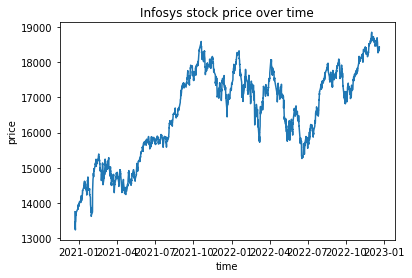

In [6]:
plt.plot(df.index, df["Close"])
plt.title("Infosys stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

# Find p, d, and q values for ARIMA model 

Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

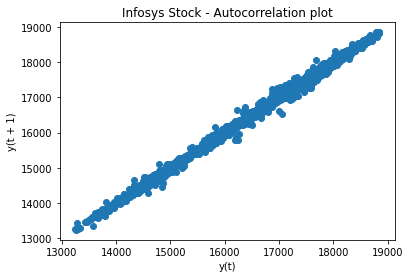

In [7]:
lag_plot(df['Close'], lag=1)
plt.title('Infosys Stock - Autocorrelation plot')
plt.show()

p is order of Autoregrassion <br>
d is order of differencing requiredd to make time series stationary <br>
q is order Moving aaverages

## Stationarity

Substract current value from previous value. We need to do diffenting peration multiple times to make series stationary. <br>
Select minimun value for ARIMA model.

### ADF test

We will use Augumented Dickey Fuller (ADF) test check stationarity in series. <br>
<br>
Null hypothesis of ADF test is that time series is non-stationary. If p-value of test is less than 0.05 then wee can reject null hypothesis. <br>
So, if p-value > 0.05 we'll find order of diffencing.  

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
dftest = adfuller(df['Close'],autolag='AIC')
print('1. ADF statistic :',dftest[0])
print('2. P-value :',dftest[1])

1. ADF statistic : -1.9089775493787509
2. P-value : 0.3278496458174832


## ## We find our series is non-stationary.

In [10]:
# from pmdarima import auto_arima
# import warnings
# warnings.filterwarnings('ignore')

## Autocorrelation Function (ACF) Plot

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

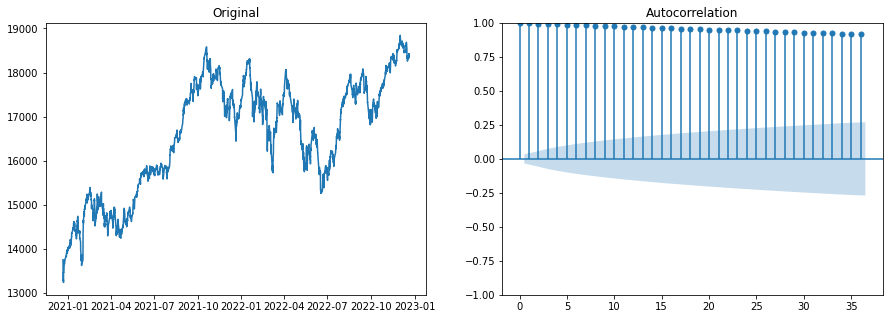

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

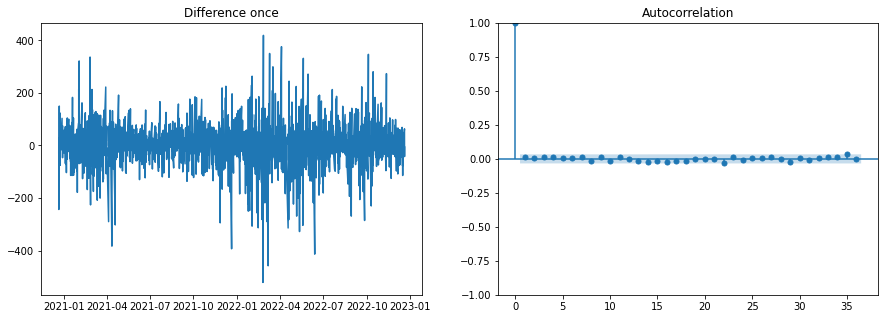

In [13]:
diff = df['Close'].diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

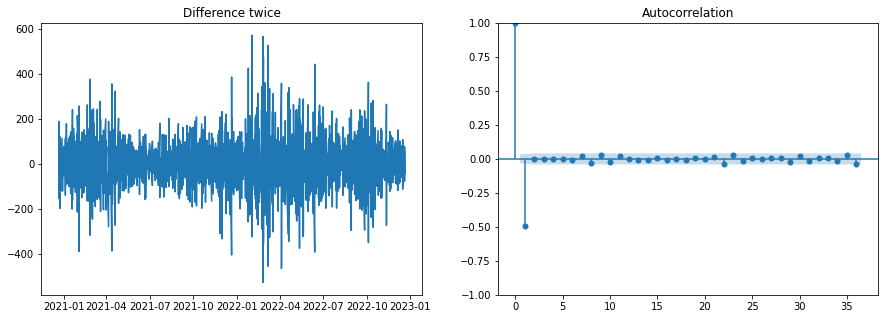

In [14]:
diff = df['Close'].diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

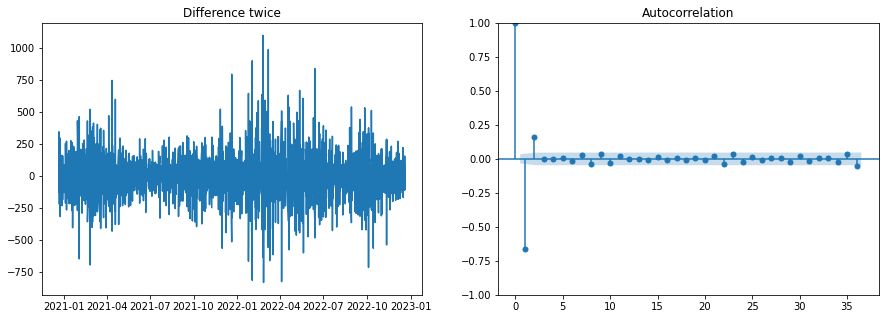

In [15]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference twice')
plot_acf(diff, ax=ax2);

## ## Here we find diffence order 3 is good.

Because there is gives positive value in third order differencing.

# p

p is the order of Auto regression (AR). It refers to number of lags to be used ass predictors. <br>
We can find required number of AR terms by inspecting Partial Autocorrelation (PACF) plot. <br>
The Partial Autocorrelation represents correlation between series and it's lags.

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

c:\Users\walde\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


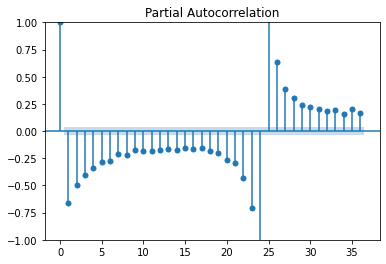

In [17]:
diff = df['Close'].diff().diff().diff().dropna()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# ax1.plot(diff)
# ax1.set_title('Difference once')
p = plot_pacf(diff);

In [18]:
# statsmodels.tsa.stattools.pacf
from statsmodels.tsa.stattools import pacf
diff = df['Close'].diff().diff().diff().dropna()
print(pacf(diff))

[ 1.         -0.66492009 -0.4998354  -0.40167648 -0.33780732 -0.28186873
 -0.2732573  -0.21213781 -0.21687804 -0.17578461 -0.18148192 -0.18502779
 -0.17777255 -0.16271642 -0.17008816 -0.15956751 -0.16362626 -0.15829954
 -0.18146284 -0.20515377 -0.2699329  -0.29270473 -0.42899054 -0.70539441
 -2.3656225   1.71952957  0.63184829  0.38536337  0.30806971  0.24270112
  0.21902136  0.20297187  0.18358371  0.19598179  0.15501505  0.19909652]


In [19]:
from statsmodels.tsa.stattools import acf
diff = df['Close'].diff().diff().diff().dropna()
print(acf(diff))

[ 1.00000000e+00 -6.64727021e-01  1.63175094e-01  1.42234568e-03
 -1.96860993e-04  3.85810043e-03 -1.41713315e-02  2.94835635e-02
 -3.92813712e-02  3.84379795e-02 -3.32443778e-02  2.11376142e-02
 -3.28252318e-03 -2.29992186e-03 -5.25595562e-03  1.09206575e-02
 -9.95846289e-03  6.82322832e-03 -8.19687290e-03  9.49415497e-03
 -9.60877681e-03  2.16941587e-02 -3.80021441e-02  3.73863993e-02
 -2.31714143e-02  1.08215969e-02 -7.35343171e-03  5.45186152e-03
  8.55025808e-03 -2.42819735e-02  2.45948097e-02 -1.54558476e-02
  5.17033829e-03  5.40832560e-03 -1.98350277e-02  3.80867880e-02]


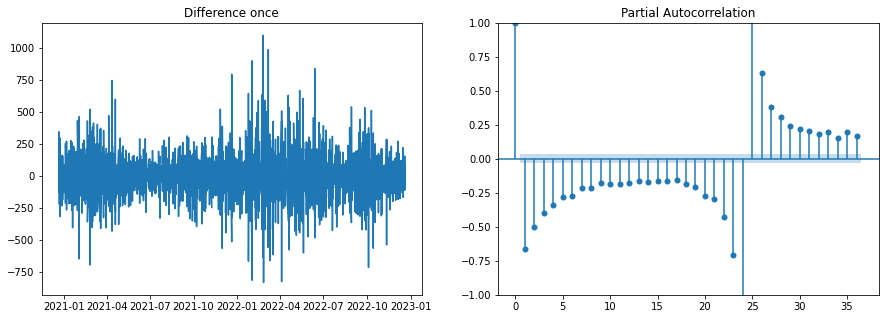

In [20]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_pacf(diff, ax=ax2);

## ## 20 is the positive value for Auto regression

# q

q is the order of moving average (MA). It refers to number of laged forecast erros that should be go into the ARIMA. <br>
We can look at ACF plot for number of MA term.

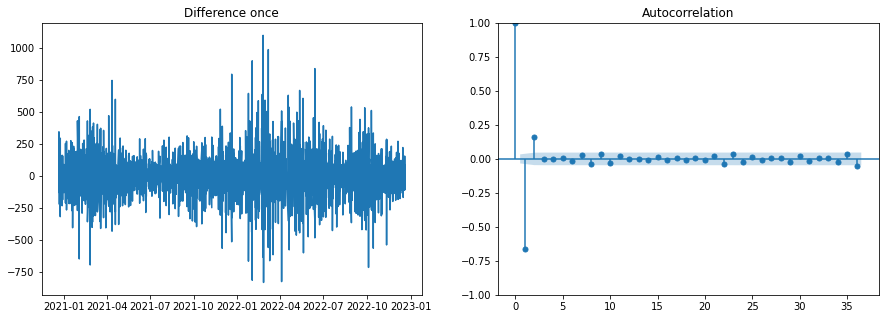

In [21]:
diff = df['Close'].diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(diff)
ax1.set_title('Difference once')
plot_acf(diff, ax=ax2);

## ## We find that 2 is no order for MA

In [22]:
# stepswise_fit = auto_arima(df['Close'], trace=True, suppress_warnings=True)
# stepswise_fit.summary()

# Let's build model

In [23]:
# train_data, test_data = df[0:int(len(df)*0.9)], df[int(len(df)*0.9):]

# training_data = train_data['Close'].values
# test_data = test_data['Close'].values

# history = [x for x in training_data]
# model_predictions = []
# N_test_observations = len(test_data)

# residuals = 0

# for time_point in range(N_test_observations):
#     model = ARIMA(history, order=(20,3,2))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     model_predictions.append(yhat)
#     true_test_value = test_data[time_point]
#     history.append(true_test_value)

#     residuals = pd.DataFrame(model_fit.resid)
    
# MSE_error = mean_squared_error(test_data, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

In [24]:
# residuals = residuals[1:]

In [25]:
# fig, ax = plt.subplots(1,2)
# residuals.plot(title="Residuals", ax=ax[0])
# residuals.plot(kind='kde', title='Density', ax=ax[1])
# plt.show()

In [26]:
# test_set_range = df[int(len(df)*0.7):]
# plt.plot(test_set_range.index, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
# plt.plot(test_set_range.index, test_data, color='red', label='Actual Price')
# plt.title('Infosys Prices Prediction')
# plt.xlabel('Date')
# plt.ylabel('Prices')
# plt.legend()
# plt.show()

In [27]:
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Date
index,,,,,,,
2022-12-16 14:15:00,18328.300781,18328.300781,18257.750000,18260.349609,18260.349609,0,NaN
2022-12-16 15:15:00,18261.150391,18278.300781,18255.699219,18270.099609,18270.099609,0,NaN
2022-12-19 09:15:00,18288.099609,18346.400391,18244.650391,18333.550781,18333.550781,0,NaN
2022-12-19 10:15:00,18333.750000,18358.349609,18322.949219,18339.449219,18339.449219,0,NaN
2022-12-19 11:15:00,18340.000000,18375.150391,18336.500000,18375.150391,18375.150391,0,NaN
2022-12-19 12:15:00,18375.400391,18383.400391,18322.050781,18333.000000,18333.000000,0,NaN
2022-12-19 13:15:00,18331.599609,18375.650391,18327.550781,18366.949219,18366.949219,0,NaN
2022-12-19 14:15:00,18366.599609,18425.050781,18352.250000,18418.699219,18418.699219,0,NaN
2022-12-19 15:15:00,18418.650391,18431.250000,18416.599609,18426.199219,18426.199219,0,NaN


In [29]:
history = [x for x in df['Close'].values]

modelF = ARIMA(history, order=(25,3,2))
model_Fit = modelF.fit()

In [36]:
future_index = pd.date_range(start='2022-11-18 09:30:00', end='2022-11-18 22:30:00', freq='1H')

In [37]:
future_index[:10]

DatetimeIndex(['2022-11-18 09:30:00', '2022-11-18 10:30:00',
               '2022-11-18 11:30:00', '2022-11-18 12:30:00',
               '2022-11-18 13:30:00', '2022-11-18 14:30:00',
               '2022-11-18 15:30:00', '2022-11-18 16:30:00',
               '2022-11-18 17:30:00', '2022-11-18 18:30:00'],
              dtype='datetime64[ns]', freq='H')

In [38]:
print(len(future_index))

14


In [39]:
output = model_Fit.forecast(steps=14)

In [40]:
output

array([18413.74498969, 18406.68931633, 18395.8346704 , 18389.91657474,
       18381.62313633, 18376.12247878, 18365.68498742, 18360.4705867 ,
       18350.49522391, 18345.37887141, 18337.77851863, 18338.00452288,
       18338.1429414 , 18336.37081175])

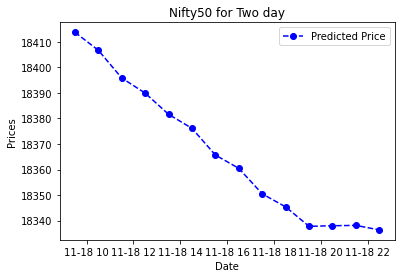

In [41]:
plt.plot(future_index, output, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.title('Nifty50 for Two day')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

1,2,1 and 0,1,0